# Building recommendations with RecTools


- Building simple model
- Visual recommendations checking

In [1]:
!pip install implicit
!pip install rectools
!pip install rectools[lightfm]
!pip install rectools[torch]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 35.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.9/115.9 kB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.4/316.4 kB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lightfm: filename=lightfm-1.17-cp310-cp310-linux_x86_64.whl size=808331 sha256=a0d6bb88835edc02cee497b510e7c906bc973f5d33ba9e4e91954350277ff619
  Stored in directory: /root/.cache/pip/wheels/4f/9b/7e/0b256f2168511d8fa4dae4fae0200fdbd729eb424a912ad636
Successfully built lightfm
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 802.2/802.2 kB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 53.9 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.w

In [23]:
import numpy as np
import pandas as pd
import os
import json
import threadpoolctl
import torch
from tqdm import tqdm
import operator
from collections import Counter

from rectools import Columns
from rectools.dataset import Dataset
from implicit.als import AlternatingLeastSquares
from rectools.models import (
    PopularModel,
    ImplicitItemKNNWrapperModel,
    ImplicitALSWrapperModel,
    LightFMWrapperModel,
    PureSVDModel,
    DSSMModel
)
from rectools.metrics import (
    IntraListDiversity,
    Serendipity,
    Accuracy,
    Precision,
    Recall,
    MRR,
    NDCG,
    calc_metrics
)
from rectools.models.dssm import DSSM
from rectools.dataset.torch_datasets import DSSMDataset

from implicit.nearest_neighbours import TFIDFRecommender
from lightfm import LightFM
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from rectools.metrics.distances import PairwiseHammingDistanceCalculator


# For implicit ALS
os.environ["OPENBLAS_NUM_THREADS"] = "1"
threadpoolctl.threadpool_limits(1, "blas")

# Load data

In [3]:
 ! mkdir ~/.kaggle
 ! cp kaggle.json ~/.kaggle/
 ! chmod 600 ~/.kaggle/kaggle.json
 ! kaggle datasets download -d dschettler8845/recsys-2020-ecommerce-dataset

Dataset URL: https://www.kaggle.com/datasets/dschettler8845/recsys-2020-ecommerce-dataset
License(s): copyright-authors
 99% 625M/629M [00:09<00:00, 56.6MB/s]
100% 629M/629M [00:09<00:00, 71.4MB/s]


In [4]:
import zipfile
zip_file_path = 'recsys-2020-ecommerce-dataset.zip'

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall()

In [5]:
data_train = pd.read_parquet('train.parquet')
data_val = pd.read_parquet('val.parquet')
data_test = pd.read_parquet('test.parquet')

In [6]:
RANDOM_STATE = 32

# Data prep

### Useful functions

In [7]:
def interactions_prep(df):
    interactions = df[df['target'] == 1]\
                      [['user_id', 'product_id', 'target', 'timestamp']] \
                      .groupby(['user_id', 'product_id', 'timestamp'], as_index=False)\
                      .aggregate({'target': 'sum'})

    interactions.rename(columns={'product_id': 'item_id',
                                   'target': 'weight',
                                   'timestamp': 'datetime'}, inplace=True)
    return interactions


def full_category(cat0_cat1_cat2_cat3):
    cat0, cat1, cat2, cat3 = cat0_cat1_cat2_cat3
    if cat3 != 'NA':
      return f'{cat0}.{cat1}.{cat2}.{cat3}'
    if cat2 != 'NA':
      return f'{cat0}.{cat1}.{cat2}'
    if cat1 != 'NA':
      return f'{cat0}.{cat1}'
    return cat0

### Prepare user-item interactions for the analysis

In [8]:
train_interactions = interactions_prep(data_train)
val_interactions = interactions_prep(data_val)
test_interactions = interactions_prep(data_test)

train_interactions.head()

,user_id,item_id,datetime,weight
0,101875240,100019252,2020-01-16 18:18:22,1
1,107620212,20500418,2020-01-30 15:10:12,1
2,128968633,15800015,2019-12-31 11:30:56,1
3,128968633,2900516,2019-12-31 10:09:41,1
4,136662675,1005008,2019-12-13 09:00:26,1


In [9]:
train_users = set(train_interactions[Columns.User].unique())
val_users = set(val_interactions[Columns.User].unique())
test_users = set(test_interactions[Columns.User].unique())
# users for metrics calculation
users = val_users.intersection(train_users)
test_users_in_train = test_users.intersection(train_users)
users.update(test_users_in_train)

In [10]:
val_interactions_warm = val_interactions[val_interactions.user_id.isin(users)].copy()

### Prepare sparce feature matrix

- Can be used with iALS, LightFM and DSSM

- ***Item features***: brand, category
- ***User features***: average purchase price and total number of purchase (both will be converted to categorical features using 10 quantiles)

#### Additional data prep:

- Add full category
- Correct data type of price column

In [11]:
data_train['full_cat'] = data_train[['cat_0', 'cat_1', 'cat_2', 'cat_3']]\
                                      .apply(full_category, axis=1)
data_train['price'] = data_train['price'].apply(float)

- Impute zero prices with mean in full category

<Axes: >

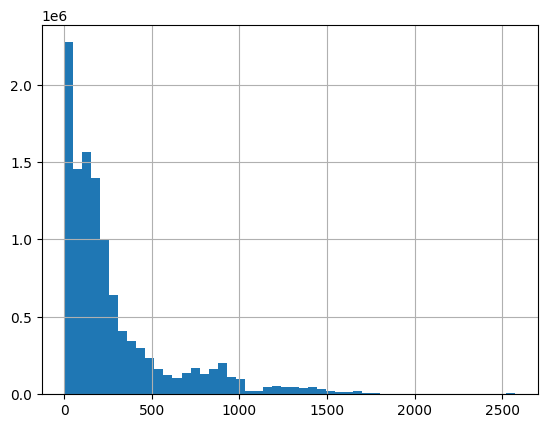

In [12]:
import numpy as np

mean_prices_per_category = data_train[data_train['price'] > 0]\
                                      .groupby('full_cat')['price'].mean()

data_train['price'] = np.where(data_train['price'] <= 0,
                               data_train['full_cat'].map(mean_prices_per_category), data_train['price'])

data_train['price'].hist(bins=50)

- Add revenue column

In [13]:
def is_revenue(event_price):
  event, price = event_price
  if event == 'purchase':
    return price
  return 0

data_train['revenue'] = data_train[['event_type', 'price']].apply(is_revenue, axis=1)

#### Sparce matrix for items with features

In [14]:
item_info = data_train[data_train['target'] == 1]\
                 .groupby(['product_id'], as_index=False)\
                 .aggregate({'brand': 'last',
                             'cat_0': 'last',
                             'full_cat': 'last',
                             'price': 'mean',
                             'revenue': 'sum'})\
                 .rename(columns={'product_id': 'item_id'})
item_info.head(5)

,item_id,brand,cat_0,full_cat,price,revenue
0,100000000,xlmedia,computers,computers.components.cooler,9.63,9.63
1,100000002,istarikomiks,computers,computers.components.cooler,9.86,9.86
2,100000003,xlmedia,NA,NA,8.28,8.28
3,100000010,NA,furniture,furniture.universal.light,3.74,3.74
4,100000016,NA,apparel,apparel.scarf,45.04,90.08


In [15]:
# Let's prepare a flatten dataframe with 2 item features
item_feature_cols = ['full_cat', 'brand']

def flatten_df(df: pd.DataFrame, id_name: str, features: list):
  features_frames = []
  for feature in features:
      feature_frame = df.reindex(columns=[id_name, feature])
      feature_frame.columns = ['id', 'value']
      feature_frame['feature'] = feature
      features_frames.append(feature_frame)
  return pd.concat(features_frames)

item_features = flatten_df(item_info, id_name='item_id', features=item_feature_cols) # 'brand'

# Let's see how this looks for items 1,2
item_features.query("id in ['100000000', '100000002']").sort_values("id")

,id,value,feature
0,100000000,computers.components.cooler,full_cat
0,100000000,xlmedia,brand
1,100000002,computers.components.cooler,full_cat
1,100000002,istarikomiks,brand


#### Sparce matrix for users by average price of purchase

In [16]:
user_info = data_train[data_train['target'] == 1] \
                        .groupby('user_id', as_index=False) \
                        .aggregate({'price': 'mean'})\
                        .rename(columns={'price': 'avg_purch_price'})

user_info['avg_purch_price_cat'] = pd.qcut(user_info['avg_purch_price'],
                                              q=10, precision=0)

user_info.drop(columns=['avg_purch_price'], inplace=True)
user_info.head()

,user_id,avg_purch_price_cat
0,101875240,"(181.0, 230.0]"
1,107620212,"(230.0, 292.0]"
2,128968633,"(80.0, 122.0]"
3,136662675,"(80.0, 122.0]"
4,145611266,"(0.0, 43.0]"


In [17]:
user_features = flatten_df(user_info, id_name='user_id', features=['avg_purch_price_cat'])
user_features.head(5)

,id,value,feature
0,101875240,"(181.0, 230.0]",avg_purch_price_cat
1,107620212,"(230.0, 292.0]",avg_purch_price_cat
2,128968633,"(80.0, 122.0]",avg_purch_price_cat
3,136662675,"(80.0, 122.0]",avg_purch_price_cat
4,145611266,"(0.0, 43.0]",avg_purch_price_cat


## Create datasets

In [18]:
dataset = Dataset.construct(train_interactions)

In [19]:
sparse_features_dataset = Dataset.construct(
    train_interactions,
    user_features_df=user_features,  # our flatten dataframe
    item_features_df=item_features,
    cat_user_features=['avg_purch_price_cat'], # these will be one-hot-encoded
    cat_item_features=item_feature_cols, #['full_cat', 'brand'],
    make_dense_user_features=False  # for `sparse` format
)

## Metrics

- For metric Intra list diversity

In [20]:
cat_dummies = pd.get_dummies(item_info[["item_id", "cat_0"]].set_index("item_id"),
                             prefix="", prefix_sep="").groupby("item_id").sum()
distance_calculator = PairwiseHammingDistanceCalculator(cat_dummies)

In [21]:
catalog = item_info.item_id.unique()

metrics = {
    "Precision@50": Precision(k=50),
    "Recall@50": Recall(k=50),
    "MRR@50": MRR(k=50),
    "NDCG@50": NDCG(k=50),
    "Serendipity@50": Serendipity(k=50),
    "IntraListDiversity@5": IntraListDiversity(k=5,
                              distance_calculator=distance_calculator)
}

In [22]:
# Parameters
K_RECOS = 50
NUM_THREADS = 32
RANDOM_STATE = 32

In [30]:
def save_recos(recos, model_name):
  recos.to_csv(f'{model_name}_model_recos.csv', index=False)

# Baseline

## Popular Model

In [ ]:
%%time
popular_model = PopularModel()
popular_model.fit(dataset)
popular_recos = popular_model.recommend(
    users=users,
    dataset=dataset,
    k=K_RECOS,
    filter_viewed=True
)

save_recos(popular_recos, 'popular')

In [ ]:
%%time
popular_metrics = calc_metrics(
    metrics,
    reco=popular_recos,
    interactions=val_interactions,
    prev_interactions=train_interactions,
    catalog=catalog
)

popular_metrics

In [74]:
%%time
popular_metrics_warm = calc_metrics(
    metrics,
    reco=popular_recos,
    interactions=val_interactions_warm,
    prev_interactions=train_interactions,
    catalog=catalog
)

popular_metrics_warm

CPU times: user 22.7 s, sys: 4.87 s, total: 27.6 s
Wall time: 30.9 s


{'Precision@50': 0.010755231121991206,
 'Recall@50': 0.19828828495163217,
 'NDCG@50': 0.014687542808581044,
 'MRR@50': 0.06265571883929678,
 'Serendipity@50': 8.747730494046513e-08}

# Collaborative filtering

## KNN Model

- Nearest neighbor: In these type of recommendation systems are recommending based on nearest neighbors, nearest neighbor approach used to find out either similar users or similar products

In [ ]:
%%time
# Fit model and generate recommendations for all users
knn_model = ImplicitItemKNNWrapperModel(TFIDFRecommender(K=K_RECOS))
knn_model.fit(dataset)
knn_recos = knn_model.recommend(
    users=users,
    dataset=dataset,
    k=K_RECOS,
    filter_viewed=True,
)

save_recos(knn_recos, 'knn')

CPU times: user 1min, sys: 437 ms, total: 1min
Wall time: 1min 4s


In [ ]:
knn_metrics = calc_metrics(
    metrics,
    reco=knn_recos,
    interactions=val_interactions,
    prev_interactions=train_interactions,
    catalog=catalog
)

knn_metrics

In [ ]:
knn_metrics_warm = calc_metrics(
    metrics,
    reco=knn_recos,
    interactions=val_interactions_warm,
    prev_interactions=train_interactions,
    catalog=catalog
)

knn_metrics_warm

## SVD Model

- SVD is used to decompose the user-item interaction matrix into lower-dimensional representations. By using SVD to perform matrix factorization, collaborative filtering recommender systems can reduce the dimensionality of the user-item matrix and improve the accuracy of the recommendations. SVD is often used in conjunction with other techniques, such as neighborhood-based collaborative filtering or matrix factorization with additional regularization terms, to further improve the performance of the recommender system.

In [ ]:
%%time
svd_model = PureSVDModel(factors=32)
svd_model.fit(dataset)
svd_recos = svd_model.recommend(
    users=users,
    dataset=dataset,
    k=K_RECOS,
    filter_viewed=True,
)

save_recos(svd_recos, 'SVD')

CPU times: user 2min 31s, sys: 22.6 s, total: 2min 54s
Wall time: 2min 59s


In [ ]:
svd_metrics = calc_metrics(
    metrics,
    reco=svd_recos,
    interactions=val_interactions,
    prev_interactions=train_interactions,
    catalog=catalog
)

svd_metrics

In [ ]:
svd_metrics_warm = calc_metrics(
    metrics,
    reco=svd_recos,
    interactions=val_interactions_warm,
    prev_interactions=train_interactions,
    catalog=catalog
)

svd_metrics_warm

{'Precision@10': 0.013116851468258804,
 'Recall@10': 0.04848161502574382,
 'Precision@5': 0.015985245411345085,
 'Recall@5': 0.029409196067996413,
 'Recall@1': 0.029409196067996413,
 'Precision@1': 0.021744187334537035,
 'NDCG@10': 0.014744481570243885,
 'NDCG@5': 0.017169806218445494,
 'MRR@10': 0.031362714157889014,
 'MRR@5': 0.02731103529507331,
 'Serendipity@10': 3.111374439311056e-06,
 'Serendipity@5': 3.2689112583234985e-06,
 'Serendipity@1': 2.993879315378035e-06}

## iALS Model (with and without user features)

- Matrix factorization: It is basically model based collaborative filtering and matrix factorization
- Can be used with user features



### Find best hyperparameters

In [ ]:
# K_RECOS = 10
# NUM_THREADS = 32
# RANDOM_STATE = 32
# ITERATIONS = 10

# def make_base_model(factors: int, regularization: float, alpha: float, fit_features_together: bool=False):
#     return ImplicitALSWrapperModel(
#         AlternatingLeastSquares(
#             factors=factors,
#             regularization=regularization,
#             alpha=alpha,
#             random_state=RANDOM_STATE,
#             use_gpu=False,
#             num_threads = NUM_THREADS,
#             iterations=ITERATIONS),
#         fit_features_together = fit_features_together,
#         )

In [ ]:
# alphas = [1, 10, 100]
# regularizations = [0.01, 0.1, 0.5]
# factors = [32, 64, 128]

# results = []

# for alpha in alphas:
#     for regularization in regularizations:
#         for n_factors in tqdm(factors):
#             model_name = f"no_features_factors_{n_factors}_alpha_{alpha}_reg_{regularization}"
#             model = make_base_model(factors=n_factors, regularization=regularization, alpha=alpha)
#             model.fit(dataset)
#             recos = model.recommend(
#                 users=users,
#                 dataset=dataset,
#                 k=K_RECOS,
#                 filter_viewed=True,
#             )
#             metric_values = calc_metrics(metrics, recos, val_interactions,
#                                          train_interactions, catalog)
#             metric_values["model"] = model_name
#             results.append(metric_values)

100%|██████████| 3/3 [14:46<00:00, 295.43s/it]


In [ ]:
# import operator
# from collections import Counter

# # results = pd.read_csv('ials_models_gs_res.csv')
# # results.set_index('model', inplace=True)

# max_metrics = []
# for metric in metrics.keys():
#   metric_dict = dict(results[metric])
#   max_metrics.append(max(metric_dict.items(), key=operator.itemgetter(1))[0])

# c = Counter(max_metrics)
# c.most_common(3)

[('no_features_factors_32_alpha_10_reg_0.01', 10),
 ('no_features_factors_128_alpha_10_reg_0.5', 3)]

### Fitting model with the best hyperparameters (without features)

In [ ]:
ials_model = ImplicitALSWrapperModel(AlternatingLeastSquares(
            factors=32,
            regularization=0.01,
            alpha=10,
            random_state=RANDOM_STATE,
            use_gpu=False,
            num_threads = NUM_THREADS,
            iterations=10))

%time
ials_model.fit(dataset)

CPU times: user 0 ns, sys: 4 µs, total: 4 µs
Wall time: 7.15 µs


/usr/local/lib/python3.10/dist-packages/rectools/dataset/features.py:420: UserWarning: Converting sparse features to dense array may cause MemoryError
  warnings.warn("Converting sparse features to dense array may cause MemoryError")


  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
%%time
ials_recos = ials_model.recommend(
    users=users,
    dataset=dataset,
    k=K_RECOS,
    filter_viewed=True,
)

save_recos(ials_recos, 'iALS')

In [ ]:
ials_metrics = calc_metrics(
    metrics,
    reco=ials_recos,
    interactions=val_interactions,
    prev_interactions=train_interactions,
    catalog=catalog
)

ials_metrics

In [ ]:
ials_metrics_warm = calc_metrics(
    metrics,
    reco=ials_recos,
    interactions=val_interactions_warm,
    prev_interactions=train_interactions,
    catalog=catalog
)

ials_metrics_warm

### Fit iALS with features

In [ ]:
ials_model_features = ImplicitALSWrapperModel(AlternatingLeastSquares(
            factors=32,
            regularization=0.01,
            alpha=10,
            random_state=RANDOM_STATE,
            use_gpu=False,
            num_threads = NUM_THREADS,
            iterations=10))

%time
ials_model_features.fit(sparse_features_dataset)

In [ ]:
%%time
ials_features_recos = ials_model_features.recommend(
    users=users,
    dataset=sparse_features_dataset,
    k=K_RECOS,
    filter_viewed=True,
)

save_recos(ials_features_recos, 'iALS_features')

In [ ]:
ials_features_metrics = calc_metrics(
    metrics,
    reco=ials_features_recos,
    interactions=val_interactions,
    prev_interactions=train_interactions,
    catalog=catalog
)

ials_features_metrics

In [ ]:
ials_features_metrics_warm = calc_metrics(
    metrics,
    reco=ials_features_recos,
    interactions=val_interactions_warm,
    prev_interactions=train_interactions,
    catalog=catalog
)

ials_features_metrics_warm

# Hybrid model

## LightFM model

- LightFM is a hybrid recommender system library that combines collaborative filtering and content-based filtering techniques. It belongs to the category of hybrid recommender systems.

- Hybrid recommender systems aim to leverage the strengths of both collaborative filtering and content-based filtering approaches to provide more accurate and diverse recommendations. LightFM incorporates both user-item interactions and additional item or user features to generate recommendations.

- Can be used with user features

### Find best hyperparameters

In [ ]:
# factors = [32, 64, 128]

# results = []

# for n_factors in tqdm(factors):
#   model_name = f"no_features_factors_{n_factors}"
#   model = LightFMWrapperModel(LightFM(no_components=n_factors, loss="bpr"),
#                                     num_threads=NUM_THREADS,
#                                     epochs=10)
#   model.fit(dataset)
#   recos = model.recommend(
#                 users=users,
#                 dataset=dataset,
#                 k=K_RECOS,
#                 filter_viewed=True,
#             )
#   metric_values = calc_metrics(metrics,
#                                recos,
#                                val_interactions,
#                                train_interactions,
#                                catalog)
#   metric_values["model"] = model_name
#   results.append(metric_values)

#   # pd.DataFrame(results).to_csv('lightfm_models_gr_res.csv')

100%|██████████| 3/3 [15:38<00:00, 312.81s/it]


In [ ]:
# import operator
# from collections import Counter

# results = pd.read_csv('lightfm_models_gr_res.csv')
# results.set_index('model', inplace=True)

# max_metrics = []
# for metric in metrics.keys():
#   metric_dict = dict(results[metric])
#   max_metrics.append(max(metric_dict.items(), key=operator.itemgetter(1))[0])

# c = Counter(max_metrics)
# c.most_common(3)

[('no_features_factors_32', 12), ('no_features_factors_64', 1)]

### Fitting model with the best hyperparameters (without features)

In [ ]:
%%time
lightfm_model = LightFMWrapperModel(LightFM(no_components=32, loss="bpr"),
                                    num_threads=NUM_THREADS,
                                    epochs=10)
lightfm_model.fit(dataset)
lightfm_recos = lightfm_model.recommend(
    users=train_interactions[Columns.User].unique(),
    dataset=dataset,
    k=K_RECOS,
    filter_viewed=True,
)

save_recos(lightfm_recos, 'LightFM')

CPU times: user 22min 30s, sys: 3min 18s, total: 25min 48s
Wall time: 15min 21s


In [ ]:
lightfm_metrics = calc_metrics(
    metrics,
    reco=lightfm_recos,
    interactions=val_interactions,
    prev_interactions=train_interactions,
    catalog=catalog
)

lightfm_metrics

In [ ]:
lightfm_metrics_warm = calc_metrics(
    metrics,
    reco=lightfm_recos,
    interactions=val_interactions_warm,
    prev_interactions=train_interactions,
    catalog=catalog
)

lightfm_metrics_warm

#### Fit lightfm with features

In [ ]:
%%time
lightfm_model_features = LightFMWrapperModel(LightFM(no_components=32, loss="bpr"),
                                    num_threads=NUM_THREADS,
                                    epochs=10)
lightfm_model_features.fit(sparse_features_dataset)

In [ ]:
lightfm_features_recos = lightfm_model_features.recommend(
    users=train_interactions[Columns.User].unique(),
    dataset=sparse_features_dataset,
    k=K_RECOS,
    filter_viewed=True,
)

save_recos(lightfm_features_recos, 'LightFM_features')

In [ ]:
lightfm_features_metrics = calc_metrics(
    metrics,
    reco=lightfm_features_recos,
    interactions=val_interactions,
    prev_interactions=train_interactions,
    catalog=catalog
)

lightfm_features_metrics

In [ ]:
lightfm_features_metrics_warm = calc_metrics(
    metrics,
    reco=lightfm_features_recos,
    interactions=val_interactions_warm,
    prev_interactions=train_interactions,
    catalog=catalog
)

lightfm_features_metrics_warm

# Deep Learning Model

## DSSM Model

In [ ]:
# user_features_short = user_features.head(100000).copy()
# train_interactions_short = train_interactions[
#     train_interactions['user_id'].isin(user_features_short.id.unique())].copy()
# item_features_short = item_features[item_features.id.isin(train_interactions_short.item_id.unique())]

In [ ]:
# sparse_features_dataset_short = Dataset.construct(
#     train_interactions_short,
#     user_features_df=user_features_short,  # our flatten dataframe
#     item_features_df=item_features_short,
#     cat_user_features=['avg_purch_price_cat'], # these will be one-hot-encoded
#     cat_item_features=['cat_0'],  # 'brand'
#     make_dense_user_features=False  # for `sparse` format
# )

In [82]:
dssm_dataset = DSSMDataset.from_dataset(sparse_features_dataset)
dssm_model_parametrized = DSSM(
    n_factors_user=20,
    n_factors_item=20,
    dim_input_user=sparse_features_dataset.user_features.get_sparse().shape[1],
    dim_input_item=sparse_features_dataset.item_features.get_sparse().shape[1],
    dim_interactions=sparse_features_dataset.get_user_item_matrix().shape[1])

In [ ]:
dssm_model = DSSMModel(dssm_dataset,
                       max_epochs=10,
                       model=dssm_model_parametrized,
                       batch_size=2048,
                       dataloader_num_workers=2,
                       trainer_accelerator='cuda'
                 )
dssm_model.fit(sparse_features_dataset)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name     | Type    | Params
-------------------------------------
0 | user_net | UserNet | 388 K 
1 | item_net | ItemNet | 1.6 K 
-------------------------------------
389 K     Trainable params
0         Non-trainable params
389 K     Total params
1.559     Total estimated model params size (MB)
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarn

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


In [ ]:
dssm_recos = dssm_model.recommend(
    users=users,
    dataset=sparse_features_dataset,
    k=K_RECOS,
    filter_viewed=True,
)

save_recos(dssm_recos, 'DSSM_features')

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


In [ ]:
dssm_metrics = calc_metrics(
    metrics,
    reco=dssm_recos,
    interactions=val_interactions,
    prev_interactions=train_interactions,
    catalog=catalog
)

dssm_metrics

In [ ]:
dssm_metrics_warm = calc_metrics(
    metrics,
    reco=dssm_recos,
    interactions=val_interactions_warm,
    prev_interactions=train_interactions,
    catalog=catalog
)

dssm_metrics_warm

{'Precision@10': 0.00010317244089916345,
 'Recall@10': 0.0004898474280449257,
 'Precision@5': 0.00010942531610517336,
 'Recall@5': 0.00023913801248756495,
 'Recall@1': 0.00023913801248756495,
 'Precision@1': 5.359607319437063e-05,
 'NDCG@10': 0.0001071051717786736,
 'NDCG@5': 0.00010847977282523381,
 'MRR@10': 0.0002527744297955601,
 'MRR@5': 0.00019257366854699554}

# Models comparison

#### Saved metrics

#### Metrics (warm + cold)

In [ ]:
popular_metrics = {'model': 'Most popular',
                   'population': 'cold',

}

popular_metrics_warm = {'model': 'Most popular',
                   'population': 'warm',

}

knn_metrics = {}

knn_metrics_warm = {}

svd_metrics = {}

svd_metrics_warm = {}

ials_metrics = {}

ials_metrics_warm = {}

ials_with_features_metrics = {}

ials_with_features_metrics_warm = {}

lightfm_metrics = {}

lightfm_metrics_warm = {}

lightfm_with_features_metrics = {}

lightfm_with_features_metrics_warm = {}

dssm_metrics = {}

dssm_metrics_warm = {}

#### Metrics comparison table

In [ ]:
popular_metrics['model'] = 'Popular'
knn_metrics['model'] = 'KNN'
svd_metrics['model'] = 'SVD'
ials_metrics['model'] = 'iALS'
lightfm_metrics['model'] = 'LightFM'

experiments = [popular_metrics, knn_metrics, svd_metrics, ials_metrics, lightfm_metrics]

experiments_df = pd.DataFrame.from_records(experiments, index=['model']).T
experiments_df.round(6)

model,Popular,KNN,SVD,iALS,LightFM
Precision@10,0.026868,0.019628,0.013117,0.024217,0.001564
Recall@10,0.098936,0.066865,0.048482,0.087414,0.004555
Precision@5,0.034136,0.027539,0.015985,0.031555,0.001584
Recall@5,0.062675,0.047560,0.029409,0.057788,0.002272
Recall@1,0.062675,0.047560,0.029409,0.057788,0.002272
Precision@1,0.033386,0.045671,0.021744,0.048534,0.000449
NDCG@10,0.028845,0.024508,0.014744,0.028717,0.001400
NDCG@5,0.033670,0.031369,0.017170,0.035048,0.001318
MRR@10,0.057008,0.052658,0.031363,0.061402,0.002227
MRR@5,0.050165,0.048774,0.027311,0.055529,0.001637


In [ ]:
experiments_df.reset_index()

In [ ]:

pd.melt(experiments_df, id_vars=['A'], value_vars=['B', 'C'])

In [ ]:
import plotly.express as px

fig = px.scatter(experiments_df, y="nation", x="count",
                 color="medal", symbol="medal")
fig.update_traces(marker_size=10)
fig.show()

## Check recommendations

In [ ]:
# Select random user, see history of views and reco for this user
user_id = '136662675'
user_viewed = train_interactions.query("user_id == @user_id").merge(item_info, on="item_id")
user_recos = recos.query("user_id == @user_id").merge(item_info, on="item_id")

In [ ]:
# History, but only films that user likes
user_viewed

,user_id,item_id,datetime,weight,brand,cat_0,cat_1,price
0,136662675,1005008,2019-12-13 09:00:26,1,xiaomi,construction,tools,94.98


In [ ]:
# Recommendations
user_recos.sort_values("rank")

,user_id,item_id,score,rank,brand,cat_0,cat_1,price
0,136662675,1005007,0.092387,1,xiaomi,construction,tools,96.85
1,136662675,1005006,0.091551,2,xiaomi,construction,tools,90.74
2,136662675,1005203,0.073311,3,xiaomi,construction,tools,101.26
3,136662675,1005009,0.063981,4,xiaomi,construction,tools,89.81
4,136662675,17700646,0.057660,5,NA,apparel,shoes,2.96
5,136662675,1004903,0.039563,6,huawei,construction,tools,114.04
6,136662675,1005195,0.039132,7,xiaomi,construction,tools,102.67
7,136662675,58100195,0.037740,8,organicshop,accessories,bag,2.65
8,136662675,38700061,0.037740,9,lumene,furniture,bedroom,6.14
